Using Theano backend.
1 #define _CUDA_NDARRAY_C
2 
3 #include <Python.h>
4 #include <structmember.h>
5 #include "theano_mod_helper.h"
6 
7 #include <numpy/arrayobject.h>
8 #include <iostream>
9 
10 #include "cuda_ndarray.cuh"
11 
12 #ifndef CNMEM_DLLEXPORT
13 #define CNMEM_DLLEXPORT
14 #endif
15 
16 #include "cnmem.h"
17 #include "cnmem.cpp"
18 
19 //If true, when there is a gpu malloc or free error, we print the size of allocated memory on the device.
20 #define COMPUTE_GPU_MEM_USED 0
21 
22 //If true, we fill with NAN allocated device memory.
23 #define ALLOC_MEMSET 0
24 
25 //If true, we print out when we free a device pointer, uninitialize a
26 //CudaNdarray, or allocate a device pointer
27 #define PRINT_FREE_MALLOC 0
28 
29 //If true, we do error checking at the start of functions, to make sure there
30 //is not a pre-existing error when the function is called.
31 //You probably need to set the environment variable
32 //CUDA_LAUNCH_BLOCKING=1, and/or modify the CNDA_THREAD_SYNC
33

380         work_size = 0;
381     return work_mem;
382 }
383 
384 /////////////////////////
385 // Static helper methods
386 /////////////////////////
387 
388 static void
389 CudaNdarray_null_init(CudaNdarray*self)
390 {
391     self->base = NULL;
392     self->nd = -1;
393     self->host_structure = NULL;
394     self->data_allocated = 0;
395     self->dev_structure_fresh = 1;
396     self->dev_structure = NULL;
397     self->devdata = NULL;
398 }
399 
400 static int
401 CudaNdarray_uninit(CudaNdarray*self)
402 {
403     #if PRINT_FREE_MALLOC
404         fprintf(stderr, "CudaNdarray_uninit %p\n", self);
405     #endif
406     int rval = 0;
407     if (self->data_allocated) {
408         assert(self->devdata);
409         if (device_free(self->devdata))
410         {
411             fprintf(stderr,
412                     "CudaNdarray_uninit: error freeing self->devdata. (self=%p, self->devata=%p)\n",
413                     self, self->devdata);
414             rval = -1;
415       

1530     CNDA_THREAD_SYNC;
1531     cudaError_t err = cudaGetLastError();
1532     if( cudaSuccess != err)
1533     {
1534         PyErr_Format(PyExc_RuntimeError, "Cuda error: %s: %s.\n", "kAdd", cudaGetErrorString(err));
1535         Py_DECREF(rval);
1536         return NULL;
1537     }
1538     return (PyObject *) rval;
1539 }
1540 
1541 template <int operator_num>
1542 __global__ void k_ielem_3(const int d0, const int d1, const int d2,
1543         float* a, const int sA0, const int sA1, const int sA2,
1544         const float* b, const int sB0, const int sB1, const int sB2){
1545     for (int i0 = blockIdx.x; i0 < d0; i0 += gridDim.x){
1546         for (int i1 = blockIdx.y; i1 < d1; i1 += gridDim.y){
1547             for (int i2 = threadIdx.x; i2 < d2; i2 += blockDim.x){
1548                 switch (operator_num)
1549                 {
1550                   case IADD:
1551                     a[i0*sA0 + i1*sA1 + i2*sA2] += b[i0*sB0 + i1*sB1 + i2*sB2];
1552                     bre

2917                      cudaGetErrorString(err));
2918         return NULL;
2919     }
2920     return PyTuple_Pack(2, PyLong_FromSize_t(free), PyLong_FromSize_t(total));
2921 }
2922 
2923 /*
2924  * Synchronize with all the gpu device stream.
2925  */
2926 PyObject *
2927 CudaNdarray_synchronize(PyObject* _unused, PyObject* dummy)
2928 {
2929     CNDA_BEGIN_ALLOW_THREADS
2930     cudaThreadSynchronize();
2931     CNDA_END_ALLOW_THREADS
2932     Py_INCREF(Py_None);
2933     return Py_None;
2934 }
2935 
2936 /*
2937  * Exist and return true if we link with cublas v2.
2938  */
2939 PyObject *
2940 CudaNdarray_cublasv2(PyObject* _unused, PyObject* dummy)
2941 {
2942     Py_INCREF(Py_True);
2943     return Py_True;
2944 }
2945 
2946 PyObject *
2947 CudaNdarray_select_a_gpu(PyObject* _unused, PyObject* dummy)
2948 {
2949     void * rval = NULL;
2950     cudaError_t err;
2951     int num_gpus = 0;
2952 
2953     err = cudaGetDeviceCount(&num_gpus);
2954     if (cudaSuccess != err){
2955   

4090                                                  (unsigned int)NUM_VECTOR_OP_BLOCKS);
4091                 const CudaNdarray * cuda_dims = other;
4092                 if(unbroadcast)
4093                     cuda_dims = self;
4094                 //copy from other into self
4095                 k_elemwise_unary_rowmajor_copy<<<n_blocks, threads_per_block>>>(
4096                         size,
4097                         (unsigned int)other->nd,
4098                         (const int *)CudaNdarray_DEV_DIMS(cuda_dims),
4099                         (const float*)CudaNdarray_DEV_DATA(other),
4100                         (const int *)CudaNdarray_DEV_STRIDES(other),
4101                         CudaNdarray_DEV_DATA(self),
4102                         (const int *)CudaNdarray_DEV_STRIDES(self));
4103                 CNDA_THREAD_SYNC;
4104                 err = cudaGetLastError();
4105                 if(verbose>1)
4106                     fprintf(stderr,
4107                           

5291     return PyBool_FromLong(CudaNdarray_is_c_contiguous(self));
5292 }
5293 
5294 int fprint_CudaNdarray(FILE * fd, const CudaNdarray *self)
5295 {
5296     cudaError_t err = cudaGetLastError();
5297     if( cudaSuccess != err)
5298     {
5299         PyErr_Format(PyExc_RuntimeError,
5300                      "Cuda error: %s: %s.",
5301                      "fprint_CudaNdarray was called with an uncleared error",
5302                      cudaGetErrorString(err));
5303         return -1;
5304     }
5305     fprintf(fd, "CudaNdarray <%p, %p> nd=%i dev_structure_fresh=%d data_allocated=%d\n",
5306             self, self->devdata, self->nd, self->dev_structure_fresh, self->data_allocated);
5307     fprintf(fd, "\tHOST_DIMS:      ");
5308     for (int i = 0; i < self->nd; ++i)
5309     {
5310         fprintf(fd, "%i\t", CudaNdarray_HOST_DIMS(self)[i]);
5311     }
5312     fprintf(fd, "\n\tHOST_STRIDES: ");
5313     for (int i = 0; i < self->nd; ++i)
5314     {
5315         fprintf(fd, 

nvcc warning : The 'compute_20', 'sm_20', and 'sm_21' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
nvcc fatal   : Cannot find compiler 'cl.exe' in PATH

['nvcc', '-shared', '-O3', '-Xlinker', '/DEBUG', '-D HAVE_ROUND', '-m64', '-Xcompiler', '-DCUDA_NDARRAY_CUH=mc72d035fdf91890f3b36710688069b2e,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,/Zi,/MD', '-I"C:\\Users\\soais\\Anaconda3\\envs\\hse-aml\\lib\\site-packages\\theano\\sandbox\\cuda"', '-I"C:\\Users\\soais\\Anaconda3\\envs\\hse-aml\\lib\\site-packages\\numpy\\core\\include"', '-I"C:\\Users\\soais\\Anaconda3\\envs\\hse-aml\\include"', '-I"C:\\Users\\soais\\Anaconda3\\envs\\hse-aml\\lib\\site-packages\\theano\\gof"', '-L"C:\\Users\\soais\\Anaconda3\\envs\\hse-aml\\libs"', '-L"C:\\Users\\soais\\Anaconda3\\envs\\hse-aml"', '-o', 'C:\\Users\\soais\\AppData\\Local\\Theano\\compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.5

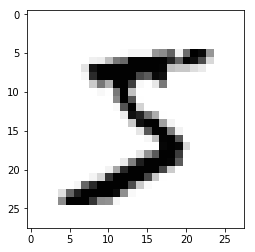

In [1]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
# parameters
num_classes = 10
h_c1 = 200
h_c2 = 50
lr_rate = 1e-3
batch_size = 100

In [14]:
# input placeholders
# image is flattened to 1-D vector
inputs = tf.placeholder(tf.float32, [None, X_train.shape[1]*X_train.shape[2]])
labels = tf.placeholder(tf.float32, [None,num_classes])

In [15]:
#build model
#layer 1 hidden unit count h_c 


# layer 1 weights
W1 = tf.Variable(tf.truncated_normal([X_train.shape[1]*X_train.shape[2], h_c1], stddev=0.01))
b1 = tf.Variable(tf.zeros(h_c1))
#layer 1 activation
h1 = tf.matmul(inputs, W1) + b1
# layer 1 output
o1 = tf.nn.relu(h1)

# layer 2 weights
W2 = tf.Variable(tf.truncated_normal([h_c1, h_c2], stddev=0.01))
b2 = tf.Variable(tf.zeros(h_c2))
#layer 2 activation
h2 = tf.matmul(o1, W2) + b2
# layer 2 output
o2 = tf.nn.relu(h2)


# final layer weights and biases
W3 = tf.Variable(tf.truncated_normal([h_c2, num_classes], stddev=0.01))
b3 = tf.Variable(tf.zeros(num_classes))
# final layer activation
logits = tf.matmul(o2, W3) + b3
predictions = tf.nn.softmax(logits)

In [16]:
# loss and optimizer
loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits))
optimizer = tf.train.AdamOptimizer(learning_rate=lr_rate).minimize(loss)
accuracy = tf.reduce_sum(tf.cast(tf.equal(tf.argmax(predictions, 1), tf.argmax(labels, 1)), tf.float32))

In [20]:
#training
epochs = 7
training_loss = []
validation_loss = []

with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())
    iteration = 0
    
    for epoch in range(epochs):
        for idx in range(0, X_train.shape[0], batch_size):
            X = X_train[idx:idx+batch_size]
            X = np.reshape(X, [X.shape[0], -1])
            y = y_train[idx:idx+batch_size]
            y = np.eye(num_classes)[y] #one hot encode
            #y = tf.one_hot(y, depth=num_classes)
            
            feed = {inputs: X, labels: y}
            t_loss, _ = sess.run([loss, optimizer], feed_dict=feed)
            
            if iteration > 400 and iteration % 100 == 0:
                #training loss on full batch
                train_loss = []
                for idx2 in range(0, X_train.shape[0], batch_size):
                    X = X_train[idx2: idx2+batch_size]
                    X = np.reshape(X, [X.shape[0], -1])
                    y = y_train[idx2:idx2+batch_size]
                    y = np.eye(num_classes)[y] #one hot encode
                    #y = y_train[idx2: idx2+batch_size]
                    train_loss.append(sess.run([loss], feed_dict = {inputs:X, labels:y}))
                
                train_loss_mean = np.mean(train_loss)
                training_loss.append(train_loss_mean)
                
                #validation_loss
                val_loss = []
                val_accuracy = []
                for idx2 in range(0, X_val.shape[0], batch_size):
                    X = X_val[idx2: idx2+batch_size]
                    X = np.reshape(X, [X.shape[0], -1])
                    y = y_val[idx2:idx2+batch_size]
                    y = np.eye(num_classes)[y] #one hot encode
                    #y = y_test[idx2: idx2+batch_size]
                    v_loss, v_acc = sess.run([loss, accuracy], feed_dict = {inputs:X, labels:y})
                    val_loss.append(v_loss)
                    val_accuracy.append(v_acc)
                
                val_loss_mean = np.mean(val_loss)
                val_accuracy_mean = np.mean(val_accuracy)
                validation_loss.append(val_loss_mean)
                
                print("After iteration {}, Training Loss={:.3f} and Val loss={:.3f}. Val Accuracy={:5.2f}".format(
                    iteration, train_loss_mean, val_loss_mean, val_accuracy_mean))
            
            iteration += 1

    #final test_loss and test accuracy
    test_loss = []
    test_accuracy = []
    for idx2 in range(0, X_test.shape[0], batch_size):
        X = X_test[idx2: idx2+batch_size]
        X = np.reshape(X, [X.shape[0], -1])
        y = y_test[idx2:idx2+batch_size]
        y = np.eye(num_classes)[y] #one hot encode
        #y = y_test[idx2: idx2+batch_size]
        t_loss, t_acc = sess.run([loss, accuracy], feed_dict = {inputs:X, labels:y})
        test_loss.append(t_loss)
        test_accuracy.append(t_acc)

    test_loss_mean = np.mean(test_loss)
    test_accuracy_mean = np.mean(test_accuracy)

    print('\n')
    print('Test Set metrics after traianing')
    print("Test loss={:.3f}. Test Accuracy={:5.2f}".format(test_loss_mean, test_accuracy_mean))
            
            

After iteration 500, Training Loss=32.633 and Val loss=30.168. Val Accuracy=91.53
After iteration 600, Training Loss=29.746 and Val loss=27.989. Val Accuracy=91.75
After iteration 700, Training Loss=28.097 and Val loss=26.356. Val Accuracy=92.47
After iteration 800, Training Loss=25.295 and Val loss=23.686. Val Accuracy=93.10
After iteration 900, Training Loss=25.008 and Val loss=24.156. Val Accuracy=93.04
After iteration 1000, Training Loss=21.298 and Val loss=20.487. Val Accuracy=94.26
After iteration 1100, Training Loss=19.743 and Val loss=19.649. Val Accuracy=94.36
After iteration 1200, Training Loss=18.380 and Val loss=18.377. Val Accuracy=94.77
After iteration 1300, Training Loss=17.249 and Val loss=17.052. Val Accuracy=95.12
After iteration 1400, Training Loss=18.016 and Val loss=18.564. Val Accuracy=94.75
After iteration 1500, Training Loss=15.426 and Val loss=15.959. Val Accuracy=95.49
After iteration 1600, Training Loss=14.354 and Val loss=15.548. Val Accuracy=95.51
After ite

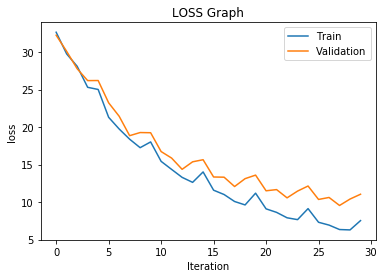

In [21]:
#plot the training and testing loss
x = [i for i in range(len(training_loss))]
plt.plot(x, training_loss, label='Train')
plt.plot(x, testing_loss, label='Validation')

plt.xlabel('Iteration')
plt.ylabel('loss')

plt.title("LOSS Graph")

plt.legend()

plt.show()